# Price elasticity of demand notebook

This notebook helps you understand the impact that changes in price will have on consumer demand for a given product. Business analysts that measure price elasticity and business users that require elasticity as an input to make pricing decisions will benefit from this notebook.

Following this workflow will allow you to identify relationships between price and demand, maximize revenue by properly pricing products, monitor price elasticities for changes in price and demand, and reduce manual processes used to obtain and update price elasticities. See the full description of the use case in the business overview for more background information.

### Import libraries

In [ ]:
import datetime
from datetime import date, timedelta

import datarobot as dr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

dr_dark_blue = "#08233F"
dr_orange = "#FF7F0E"
dr_blue = "#1F77B4"

pd.set_option("display.max_columns", None)

### Connect to DataRobot

Read more about different options for [connecting to DataRobot from the client](https://docs.datarobot.com/en/docs/api/api-quickstart/api-qs.html).

In [ ]:
# If the config file is not in the default location described in the API Quickstart guide, '~/.config/datarobot/drconfig.yaml', then you will need to call
# dr.Client(config_path='path-to-drconfig.yaml')

### Import data

Access the training dataset [here](https://datarobot.app.box.com/s/lzver7v68s3y693zgy0zqm5vvxp3br17).

In [4]:
train = pd.read_csv("1. DR_DEMO_priceOpt_training.csv")
train.head()

Date                      SKUName   Sales   PriceBaseline   \
0  7/1/12  Heck 97% Pork Sausages 400g  109673             3.25   
1  7/2/12  Heck 97% Pork Sausages 400g  131791             3.25   
2  7/3/12  Heck 97% Pork Sausages 400g  134711             3.25   
3  7/4/12  Heck 97% Pork Sausages 400g   97640             3.25   
4  7/5/12  Heck 97% Pork Sausages 400g  129538             3.25   

    PriceActual   PctOnSale  \
0           2.93       9.96   
1           2.97       8.65   
2           2.96       8.96   
3           2.92      10.08   
4           2.93       9.80   

                                           Marketing hotDay sunnyDay  \
0  July In Store Credit Card Signup Discount; In ...     No       No   
1  July In Store Credit Card Signup Discount; In ...     No       No   
2  July In Store Credit Card Signup Discount; In ...     No       No   
3  July In Store Credit Card Signup Discount; In ...    Yes       No   
4  July In Store Credit Card Signup Discount; ID5...     No       No   

   EconChangeGDP  EconJobsChange  AnnualizedCPI  
0            0.5             NaN           0.02  
1            NaN             NaN            NaN  
2            NaN             NaN            NaN  
3            NaN             NaN            NaN  
4            NaN             NaN            NaN

### Create a project

The snippets below create and configure a DataRobot project.

In [5]:
# Create a Datarobot project
proj = dr.Project.create(train, project_name="Price elasticity of demand")

In [6]:
# Create a dataframe from the training data
informative = [
    feat_list for feat_list in proj.get_featurelists() if feat_list.name == "Informative Features"
][0]
# Update the feature list by subtracting parents and adding new variables provided by DataRobot
new_fl = proj.create_featurelist("new_fl", list((set(informative.features) - {"Date (Year)"})))
# Create a new feature list to force a monotonic relationship between price and demand
mono_dec = proj.create_featurelist("mono_dec", list(({"PriceActual"})))
advanced_options = dr.AdvancedOptions(
    monotonic_decreasing_featurelist_id=mono_dec.id, only_include_monotonic_blueprints=False
)

### Initiate Autopilot

In [7]:
proj.set_target(
    target="Sales",
    mode=dr.enums.AUTOPILOT_MODE.FULL_AUTO,
    advanced_options=advanced_options,
    featurelist_id=new_fl.id,
    worker_count=-1,
)

Project(Price elasticity of demand)

### Import scoring data

Import the [scoring dataset](https://datarobot.app.box.com/s/7qgnaw595unuot3w2le9609g5wzc58ek) and use it to simulate the effects of different price levels.

In [8]:
score = pd.read_csv("2. DR_DEMO_priceOpt_forScoring.csv")
score.head()

Date                                            SKUName  PriceBaseline  \
0  2/27/20                        Heck 97% Pork Sausages 400g           3.25   
1  2/27/20  Yeo Valley Organic Greek Style Natural Yogurt ...           1.30   
2  2/27/20  Linda McCartney Rosemary Vegetarian Sausages x...           2.00   
3  2/27/20  Goodfella's Stonebaked Thin Margherita Pizza 345g           1.50   
4  2/27/20          New Covent Garden Potato & Leek Soup 600g           1.50   

   PriceActual  PctOnSale                                          Marketing  \
0         2.93       9.96  July In Store Credit Card Signup Discount; In ...   
1         1.17      10.37  July In Store Credit Card Signup Discount; In ...   
2         1.78      11.21  July In Store Credit Card Signup Discount; In ...   
3         1.33      11.09  July In Store Credit Card Signup Discount; In ...   
4         1.33      11.16  July In Store Credit Card Signup Discount; In ...   

  hotDay sunnyDay  EconChangeGDP  EconJobsChange  AnnualizedCPI  
0     No       No            0.5             NaN           0.02  
1     No       No            0.5             NaN           0.02  
2     No       No            0.5             NaN           0.02  
3     No       No            0.5             NaN           0.02  
4     No       No            0.5             NaN           0.02

In [9]:
# Create different price points in the scoring dataset
skuList = score["SKUName"].unique()
discountList = range(74, 126, 1)
discountList = [discountList / 100 for discountList in discountList]

index = pd.MultiIndex.from_product([skuList, discountList], names=["SKUName", "discountLevel"])
indexDF = pd.DataFrame(index=index).reset_index()
scorePerm = pd.merge(indexDF, score, on=["SKUName"], how="left")
scorePerm["PriceActual"] = scorePerm["discountLevel"] * scorePerm["PriceBaseline"]
scorePerm.head()

SKUName  discountLevel     Date  PriceBaseline  \
0  Heck 97% Pork Sausages 400g           0.74  2/27/20           3.25   
1  Heck 97% Pork Sausages 400g           0.75  2/27/20           3.25   
2  Heck 97% Pork Sausages 400g           0.76  2/27/20           3.25   
3  Heck 97% Pork Sausages 400g           0.77  2/27/20           3.25   
4  Heck 97% Pork Sausages 400g           0.78  2/27/20           3.25   

   PriceActual  PctOnSale                                          Marketing  \
0       2.4050       9.96  July In Store Credit Card Signup Discount; In ...   
1       2.4375       9.96  July In Store Credit Card Signup Discount; In ...   
2       2.4700       9.96  July In Store Credit Card Signup Discount; In ...   
3       2.5025       9.96  July In Store Credit Card Signup Discount; In ...   
4       2.5350       9.96  July In Store Credit Card Signup Discount; In ...   

  hotDay sunnyDay  EconChangeGDP  EconJobsChange  AnnualizedCPI  
0     No       No            0.5             NaN           0.02  
1     No       No            0.5             NaN           0.02  
2     No       No            0.5             NaN           0.02  
3     No       No            0.5             NaN           0.02  
4     No       No            0.5             NaN           0.02

In [15]:
# scorePerm.to_csv("2. DR_DEMO_priceOpt_forScoring_allPerm.csv",index=False)

### Test predictions 

Use the scoring dataset with the top-performing model to generate demand predictions for each stock keeping unit (SKU) at different price points.

In [10]:
proj = dr.Project.get(project_id="your-project-id")
model = dr.ModelRecommendation.get(
    proj.id, dr.enums.RECOMMENDED_MODEL_TYPE.RECOMMENDED_FOR_DEPLOYMENT
).get_model()

In [11]:
dataset = proj.upload_dataset(scorePerm)
pred_job = model.request_predictions(dataset.id)
preds = pred_job.get_result_when_complete()

In [12]:
predsAll = pd.concat([scorePerm, preds], axis=1)
predsAll["revenue"] = (
    predsAll["prediction"] * predsAll["PriceActual"]
)  # - predsAll['prediction']*predsAll['PriceBaseline']*0.2
predsAll.head()

SKUName  discountLevel     Date  PriceBaseline  \
0  Heck 97% Pork Sausages 400g           0.74  2/27/20           3.25   
1  Heck 97% Pork Sausages 400g           0.75  2/27/20           3.25   
2  Heck 97% Pork Sausages 400g           0.76  2/27/20           3.25   
3  Heck 97% Pork Sausages 400g           0.77  2/27/20           3.25   
4  Heck 97% Pork Sausages 400g           0.78  2/27/20           3.25   

   PriceActual  PctOnSale                                          Marketing  \
0       2.4050       9.96  July In Store Credit Card Signup Discount; In ...   
1       2.4375       9.96  July In Store Credit Card Signup Discount; In ...   
2       2.4700       9.96  July In Store Credit Card Signup Discount; In ...   
3       2.5025       9.96  July In Store Credit Card Signup Discount; In ...   
4       2.5350       9.96  July In Store Credit Card Signup Discount; In ...   

  hotDay sunnyDay  EconChangeGDP  EconJobsChange  AnnualizedCPI  row_id  \
0     No       No            0.5             NaN           0.02       0   
1     No       No            0.5             NaN           0.02       1   
2     No       No            0.5             NaN           0.02       2   
3     No       No            0.5             NaN           0.02       3   
4     No       No            0.5             NaN           0.02       4   

      prediction        revenue  
0  115643.445312  278122.485977  
1  115643.445312  281880.897949  
2  115643.445312  285639.309922  
3  115643.445312  289397.721895  
4  115643.445312  293156.133867

### View distribution of demand

Use the snippets below to view the distribution of demand for different price points for one SKU.

In [13]:
oneSKU = predsAll[predsAll["SKUName"] == "New Covent Garden Potato & Leek Soup 600g"]

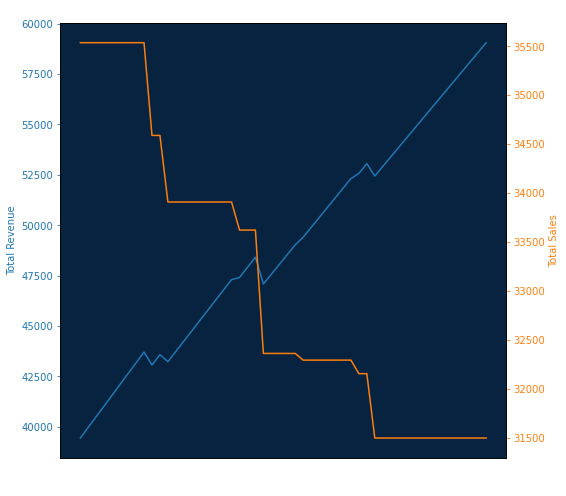

In [14]:
oneSKU = predsAll[predsAll["SKUName"] == "New Covent Garden Potato & Leek Soup 600g"]

plt.rcParams.update({"text.color": "white", "axes.labelcolor": "white"})
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(1, 1, 1, facecolor=dr_dark_blue)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
plt.title("Optimum Price Point")

ax1.set_xlabel("Change vs. Baseline Price")
ax1.tick_params(axis="x", labelcolor="white", colors="white")

ax1.set_ylabel("Total Revenue", color=dr_blue)
ax1.tick_params(axis="y", labelcolor=dr_blue, colors=dr_blue)
ax1.plot(oneSKU.discountLevel, oneSKU.revenue, color=dr_blue)

ax2.set_ylabel("Total Sales", color=dr_orange)
ax2.tick_params(axis="y", labelcolor=dr_orange, colors=dr_orange)
ax2.plot(oneSKU.discountLevel, oneSKU.prediction, color=dr_orange)

Select the price point that maximizes revenue for each SKU.

idx = predsAll.groupby(['SKUName'])['revenue'].transform(max) == predsAll['revenue']
maxSales = predsAll[idx][['SKUName','discountLevel','PriceActual']]
maxSales['discountLevel'] = ((maxSales['discountLevel'] - 1)*100).astype(int).astype(str)+"%"
finalData = pd.merge(score, maxSales, on=["SKUName"], how="left")#.drop("Row Count - 2. DR_DEMO_priceOpt_forScoring.csv",axis=1)
finalData.head(10)

### Deploy a model to production


If you are happy with the model's performance, you can deploy it to a production environment with [MLOps](https://docs.datarobot.com/en/mlops/index.html).  Deploying the model will free up workers, as data scored through the deployment doesn't use any modeling workers. Furthermore, you are no longer restricted on the amount of data to score; score over 100GB with the deployment. Deployments also offer many model management benefits: monitoring service, data drift, model comparison, retraining, and more.

In [33]:
# Retrieve a prediction server
prediction_server = dr.PredictionServer.list()[0]

# Get the top performing model. Uncomment if this did not execute in the previous section
# model_top = sorted_by_metric(models, 'crossValidation', metric)[0]

deployment = dr.Deployment.create_from_learning_model(
    model_top.id,
    label="Price elasticity",
    description="Predict the optimal price for a product based on demand",
    default_prediction_server_id=prediction_server.id,
)
deployment.id

Deployment(Late Shipment Predictions)

Before proceeding, provide the deployed model's deployment ID (retrieved from the deployment's [Overview tab](https://docs.datarobot.com/en/docs/mlops/monitor/dep-overview.html) or from the Deployment object in the Python client with "deployment.id."

### Configure batch predictions

After the model has been deployed, DataRobot creates an endpoint for real-time scoring. The deployment allows you to use DataRobot's batch prediction API to score large datasets with a deployed DataRobot model. 

The batch prediction API provides flexible intake and output options when scoring large datasets using prediction servers. The API is exposed through the DataRobot Public API and can be consumed using a REST-enabled client or Public API bindings for DataRobot's Python client.

#### Set the deployment ID

In [ ]:
deployment_id = "YOUR_DEPLOYMENT_ID"

#### Determine input and output options

DataRobot's batch prediction API allows you to score data from and to multiple sources. You can take advantage of the credentials and data sources you have already established previously through the UI for easy scoring. Credentials are usernames and passwords, while data sources are any databases with which you have previously established a connection (e.g., Snowflake). View the example code below outlining how to query credentials and data sources.

See the documentation for the full list of supported [input](https://docs.datarobot.com/en/docs/predictions/batch/batch-prediction-api/intake-options.html) and [output options](https://docs.datarobot.com/en/docs/predictions/batch/batch-prediction-api/output-options.html) and more information about [data connections](https://docs.datarobot.com/en/docs/data/connect-data/data-conn.html).

The snippet below shows how you can query all credentials tied to a DataRobot account.

In [ ]:
dr.Credential.list()

The output above returns multiple sets of credentials. The alphanumeric string included in each item of the list is the credentials ID. You can use that ID to access credentials through the API.

The snippet below shows how you can query all data sources tied to a DataRobot account. The second line lists each datastore with an alphanumeric string; that is the datastore ID.

In [6]:
dr.DataStore.list()
print(dr.DataStore.list()[0].id)

5e6696ff820e737a5bd78430


### Scoring examples

The snippets below demonstrate how to score data with the Batch Prediction API. Edit the `intake_settings` and `output_settings` to suit your needs. You can mix and match until you get the outcome you prefer.

#### Score from CSV to CSV

In [ ]:
# Scoring without Prediction Explanations
if False:
    dr.BatchPredictionJob.score(
        deployment_id,
        intake_settings={
            "type": "localFile",
            "file": "inputfile.csv",  # Provide the filepath, Pandas dataframe, or file-like object here
        },
        output_settings={"type": "localFile", "path": "outputfile.csv"},
    )

# Scoring with Prediction Explanations
if False:
    dr.BatchPredictionJob.score(
        deployment_id,
        intake_settings={
            "type": "localFile",
            "file": "inputfile.csv",  # Provide the filepath, Pandas dataframe, or file-like object here
        },
        output_settings={"type": "localFile", "path": "outputfile.csv"},
        max_explanations=3,  # Compute Prediction Explanations for the amount of features indicated here
    )

#### Score from S3 to S3

In [ ]:
if False:
    dr.BatchPredictionJob.score(
        deployment_id,
        intake_settings={
            "type": "s3",
            "url": "s3://theos-test-bucket/lending_club_scoring.csv",  # Provide the URL of your datastore here
            "credential_id": "YOUR_CREDENTIAL_ID_FROM_ABOVE",  # Provide your credentials here
        },
        output_settings={
            "type": "s3",
            "url": "s3://theos-test-bucket/lending_club_scored2.csv",
            "credential_id": "YOUR_CREDENTIAL_ID_FROM_ABOVE",
        },
    )

#### Score from JDBC to JDBC

In [ ]:
if False:
    dr.BatchPredictionJob.score(
        deployment_id,
        intake_settings={
            "type": "jdbc",
            "table": "table_name",
            "schema": "public",
            "dataStoreId": data_store.id,  # Provide the ID of your datastore here
            "credentialId": cred.credential_id,  # Provide your credentials here
        },
        output_settings={
            "type": "jdbc",
            "table": "table_name",
            "schema": "public",
            "statementType": "insert",
            "dataStoreId": data_store.id,
            "credentialId": cred.credential_id,
        },
    )